<a href="https://colab.research.google.com/github/cedro3/StyleCLIP_G/blob/master/StyleCLIP_G_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# セットアップ

In [ ]:
'''
# githubからコードを取得
! git clone https://github.com/cedro3/StyleCLIP_G.git
%cd StyleCLIP_G

# Pytorch バージョン変更
! pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 -f https://download.pytorch.org/whl/torch_stable.html 

# CLIP インストール
! pip install git+https://github.com/openai/CLIP.git
! pipi install ftfy regex

# 学習済みパラメータのダウンロード
!wget https://github.com/lernapparat/lernapparat/releases/download/v2019-02-01/karras2019stylegan-ffhq-1024x1024.for_g_all.pt
'''

# テキストから顔画像を生成

In [1]:
text = "She is a charming woman with red hair and blue eyes"

USING  cuda


100%|██████████| 101/101 [00:38<00:00,  2.63it/s]


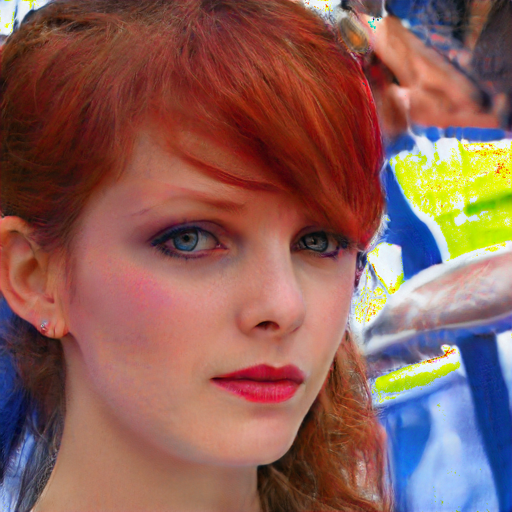

In [2]:
import os
import torch
import torchvision
import clip
import numpy as np
from PIL import Image
from stylegan_models import g_all, g_synthesis, g_mapping
from utils import GetFeatureMaps, transform_img, compute_loss
from tqdm import trange
import warnings  
warnings.filterwarnings('ignore')   

# picフォルダーリセット
import os
import shutil
if os.path.isdir('pic'):
     shutil.rmtree('pic')
os.makedirs('pic', exist_ok=True)

# 初期設定 
lr = 1e-2 
img_save_freq = 2
max_iter = 101 
ref_img_path = None 

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("USING ", device)

clip_model, clip_preprocess = clip.load("ViT-B/32", device=device)
vgg16 = torchvision.models.vgg16(pretrained=True).to(device)
vgg_layers = vgg16.features

vgg_layer_name_mapping = {
    '1': "relu1_1",
    '3': "relu1_2",
    '6': "relu2_1",
    '8': "relu2_2",
    # '15': "relu3_3",
    # '22': "relu4_3"
}

g_synthesis.eval()
g_synthesis.to(device)

latent_shape = (1, 1, 512)

normal_generator = torch.distributions.normal.Normal(
    torch.tensor([0.0]),
    torch.tensor([1.]),
)

# init_latents = normal_generator.sample(latent_shape).squeeze(-1).to(device)
latents_init = torch.zeros(latent_shape).squeeze(-1).to(device)
latents = torch.nn.Parameter(latents_init, requires_grad=True)

optimizer = torch.optim.Adam(
    params=[latents],
    lr=lr,
    betas=(0.9, 0.999),
)

def truncation(x, threshold=0.7, max_layer=8):
    avg_latent = torch.zeros(1, x.size(1), 512).to(device)
    interp = torch.lerp(avg_latent, x, threshold)
    do_trunc = (torch.arange(x.size(1)) < max_layer).view(1, -1, 1).to(device)
    return torch.where(do_trunc, interp, x)

def tensor_to_pil_img(img):
    img = (img.clamp(-1, 1) + 1) / 2.0
    img = img[0].permute(1, 2, 0).detach().cpu().numpy() * 256
    img = Image.fromarray(img.astype('uint8'))
    return img


clip_transform = torchvision.transforms.Compose([
    # clip_preprocess.transforms[2],
    clip_preprocess.transforms[4],
])

if ref_img_path is None:
    ref_img = None
else:
    ref_img = clip_preprocess(Image.open(ref_img_path)).unsqueeze(0).to(device)

clip_normalize = torchvision.transforms.Normalize(
    mean=(0.48145466, 0.4578275, 0.40821073),
    std=(0.26862954, 0.26130258, 0.27577711),
)

def compute_clip_loss(img, text):
    # img = clip_transform(img)
    img = torch.nn.functional.upsample_bilinear(img, (224, 224))
    tokenized_text = clip.tokenize([text]).to(device)
    img_logits, _text_logits = clip_model(img, tokenized_text)
    return 1/img_logits * 100

def compute_perceptual_loss(gen_img, ref_img):
    gen_img = torch.nn.functional.upsample_bilinear(img, (224, 224))
    loss = 0
    len_vgg_layer_mappings = int(max(vgg_layer_name_mapping.keys()))
    ref_feats = ref_img
    gen_feats = gen_img

    for idx, (name, module) in enumerate(vgg_layers._modules.items()):
        ref_feats = module(ref_feats)
        gen_feats = module(gen_feats)
        if name in vgg_layer_name_mapping.keys():
            loss += torch.nn.functional.mse_loss(ref_feats, gen_feats)
        
        if idx >= len_vgg_layer_mappings:
            break
    
    return loss/len_vgg_layer_mappings

counter = 0
for i in trange(max_iter):
    dlatents = latents.repeat(1,18,1)
    img = g_synthesis(dlatents)
    loss = compute_clip_loss(img, text) 
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if i % img_save_freq == 0:
        img = tensor_to_pil_img(img)
        img = img.resize((512,512))  
        img.save(os.path.join('./pic', str(counter).zfill(6)+'.png')) 
        counter +=1 

# 最終画像を表示
from IPython.display import Image, display_png
display_png(Image('./pic/'+str(counter-1).zfill(6)+'.png'))

In [ ]:
# --- 静止画からmp4を作成 ---

# 既に output.mp4 があれば削除する
import os
if os.path.exists('./output.mp4'):
   os.remove('./output.mp4')

# pic フォルダーの静止画から動画を作成
! ffmpeg -r 15 -i pic/%6d.png\
               -vcodec libx264 -pix_fmt yuv420p output.mp4

# movieフォルダへ名前を付けてコピー
import shutil
os.makedirs('movie', exist_ok=True)
shutil.copy('output.mp4', 'movie/'+text+'.mp4')

In [ ]:
# --- mp4動画の再生 ---
from IPython.display import HTML
from base64 import b64encode

mp4 = open('./output.mp4', 'rb').read()
data_url = 'data:video/mp4;base64,' + b64encode(mp4).decode()
HTML(f"""
<video width="50%" height="50%" controls>
      <source src="{data_url}" type="video/mp4">
</video>""")